In [147]:
import os
import sys
import itertools
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns

import torch
from torch import nn, optim
from transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM#, BertLayer, BertEmbeddings
from transformers.modeling_bert import BertLayer, BertEmbeddings

In [21]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
DEVICE = 'cpu'

In [23]:
ls ../mnt/checkpoints/e027/

0/  1/  2/


In [115]:
cpt = torch.load('../mnt/checkpoints/e012/0/fold_0_epoch_3_0.37636_0.37515_checkpoint.pth')

In [97]:
cpt = torch.load('../mnt/checkpoints/e027/0/fold_0_epoch_3_0.04212_0.37204_checkpoint.pth')

In [5]:
cpt.keys()

dict_keys(['current_fold', 'current_epoch', 'model_state_dict', 'optim_state_dict', 'scheduler_state_dict', 'histories', 'val_y_preds', 'val_y_trues', 'val_qa_ids'])

In [116]:
y_preds = cpt['val_y_preds']
y_trues = cpt['val_y_trues']

In [9]:
pd.DataFrame(y_trues).nunique()

0      9
1      9
2      5
3      5
4      5
5      5
6      9
7      9
8      5
9      4
10     5
11     5
12     5
13     5
14     5
15     5
16     5
17     5
18     5
19     2
20     9
21     8
22     9
23     7
24     9
25    17
26     5
27     5
28     5
29     8
dtype: int64

In [129]:
def assign_nearest_labels(preds, trues):
    assigned_preds = []
    for col_id in tqdm(list(range(30))):
        uniq_trues = np.unique(trues[:, col_id]).tolist()
        assigned_col_preds = []
        for pred in preds[:, col_id]:
            min_margin = 100
            for uniq_true in uniq_trues:
                margin = abs(pred - uniq_true)
                if margin < min_margin:
                    temp_assined_col_preds = uniq_true
                    min_margin = margin
            assigned_col_preds.append(temp_assined_col_preds)
        if len(np.unique(assigned_col_preds)) == 1:
            if assigned_col_preds[0] == np.max(uniq_true):
                assigned_col_preds[np.argmin(preds[:, col_id])] = np.min(uniq_trues)
            else:
                assigned_col_preds[np.argmax(preds[:, col_id])] = np.max(uniq_trues)
        assigned_preds.append(assigned_col_preds)
    return np.asarray(assigned_preds).T

In [27]:
from scipy.stats import spearmanr

def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(
            spearmanr(
                col_trues,
                col_pred
#                  + np.random.normal(
#                     0,
#                     1e-7,
#                     col_pred.shape[0])
            ).correlation)
    return rhos

In [28]:
np.mean(compute_spearmanr(y_trues, y_preds))

0.37204447144815067

In [29]:
np.mean(compute_spearmanr(y_trues, y_preds * 1000 // 10))

0.3703345776458123

In [130]:
# %debug
assigned_y_preds = assign_nearest_labels(y_preds, y_trues)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
assigned_y_preds

array([[1.        , 0.77777778, 0.33333333, ..., 0.33333333, 0.33333333,
        0.88888889],
       [0.83333333, 0.44444444, 0.        , ..., 0.        , 0.33333333,
        0.88888889],
       [0.88888889, 0.66666667, 0.        , ..., 0.33333333, 0.        ,
        0.88888889],
       ...,
       [0.88888889, 0.77777778, 0.        , ..., 0.        , 0.5       ,
        0.88888889],
       [1.        , 0.77777778, 0.        , ..., 0.33333333, 0.        ,
        0.88888889],
       [0.88888889, 0.55555556, 0.        , ..., 0.        , 0.33333333,
        0.88888889]])

In [14]:
(y_trues == assigned_y_preds).mean()

0.5433936403508772

In [15]:
assigned_y_preds[:, 0]

array([1.        , 0.83333333, 0.88888889, ..., 0.88888889, 1.        ,
       0.88888889])

In [16]:
y_preds[:, 0]

array([0.967108  , 0.8169023 , 0.90407753, ..., 0.9175416 , 0.9587146 ,
       0.9277595 ], dtype=float32)

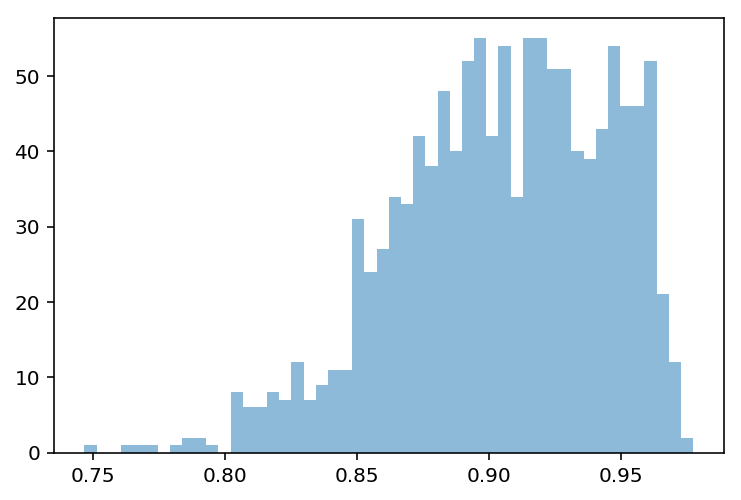

In [17]:
plt.hist(y_preds[:, 0], bins=50, alpha=0.5)
plt.show()

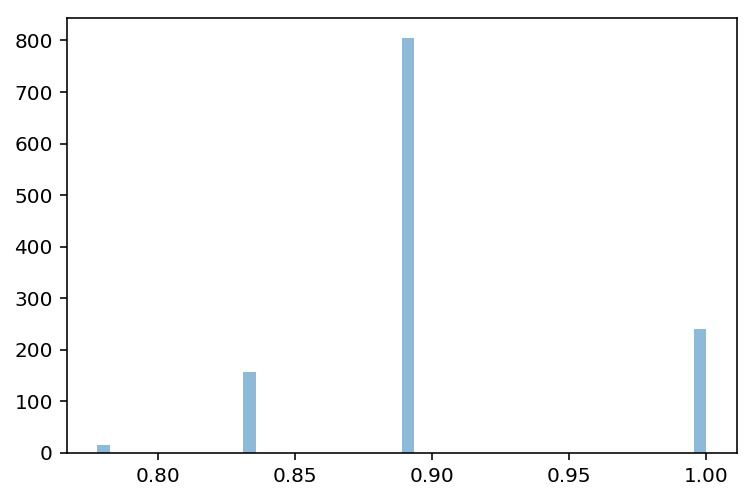

In [18]:
plt.hist(assigned_y_preds[:, 0], bins=50, alpha=0.5)
plt.show()

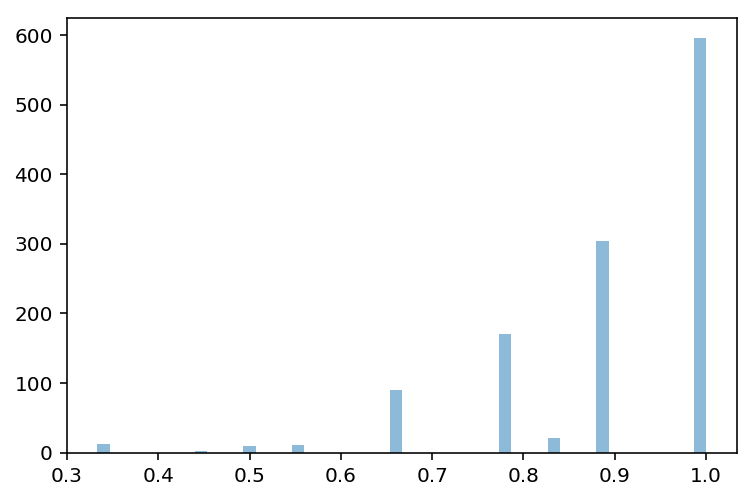

In [19]:
plt.hist(y_trues[:, 0], bins=50, alpha=0.5)
plt.show()

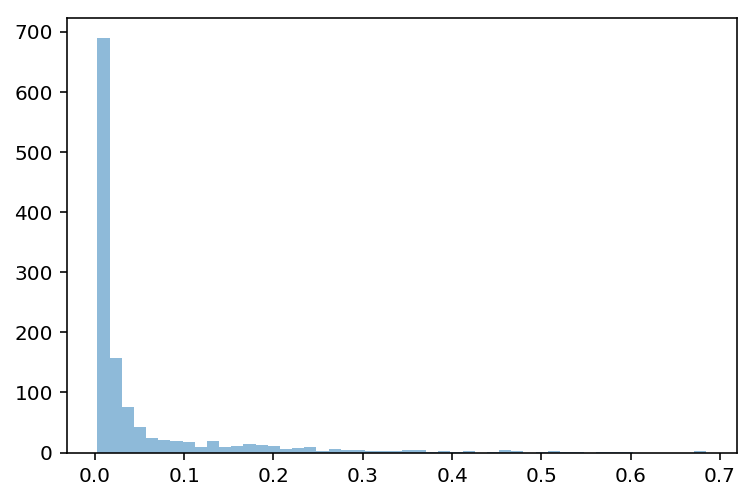

In [72]:
plt.hist(y_preds[:, 2], bins=50, alpha=0.5)
plt.show()

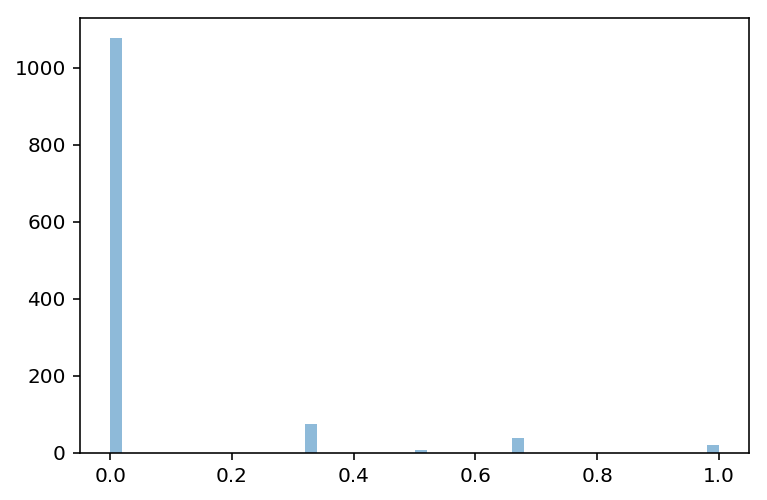

In [70]:
plt.hist(y_trues[:, 2], bins=50, alpha=0.5)
plt.show()

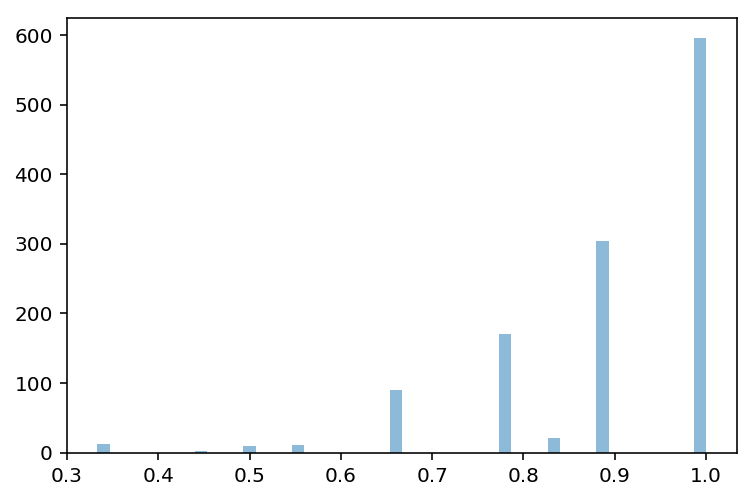

In [68]:
plt.hist(y_trues[:, 0], bins=50, alpha=0.5)
plt.show()

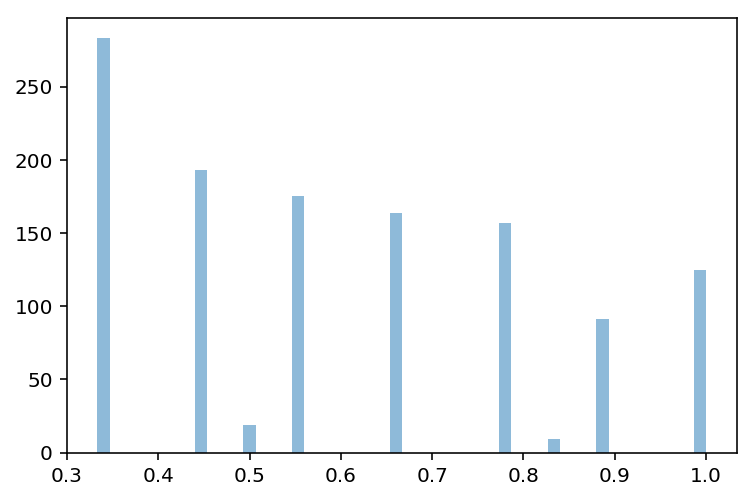

In [69]:
plt.hist(y_trues[:, 1], bins=50, alpha=0.5)
plt.show()

In [64]:
y_trues[:, 0]

array([1.        , 1.        , 0.88888889, ..., 1.        , 1.        ,
       0.55555556])

In [94]:
pd.Series(compute_spearmanr(y_trues, assigned_y_preds)).dropna().mean()

0.4020795355177934

In [117]:
compute_spearmanr(y_trues, assigned_y_preds)

[0.33694931413303936,
 0.5525639350710876,
 0.3514474183190364,
 0.2790888271349788,
 0.32845886497854104,
 0.4718309500798249,
 0.30166672081003904,
 0.4616868042196653,
 0.4717855816387441,
 -0.003415984857890416,
 0.40183148092510923,
 0.7008105302924496,
 0.4343182161053076,
 -0.0045624210801053135,
 0.5337619564287965,
 0.5680669608518802,
 0.7703271971978511,
 0.30327653885548134,
 0.5896460332270635,
 -0.0008230452674897118,
 0.438142569365688,
 0.20426918996372181,
 0.3569257568408338,
 0.042490688054867144,
 0.14127863610770514,
 0.24918357377616956,
 0.7471845567539979,
 0.16108587246863346,
 0.6114954390512181,
 0.046573846328690896]

In [118]:
compute_spearmanr(y_trues, y_preds)

[0.3856205266786172,
 0.5642944592519713,
 0.3648977582400921,
 0.2807956949964488,
 0.3407843836222576,
 0.41629700238625356,
 0.33256336947298026,
 0.4603482186215454,
 0.4895274877110685,
 0.08230136471024098,
 0.4315544827430897,
 0.6977130369880749,
 0.3447266306677803,
 0.1426499364340046,
 0.3635422315645105,
 0.49749729882651605,
 0.7675576318980243,
 0.3468981396755381,
 0.6060694289979107,
 0.02047277842728809,
 0.4533002553260622,
 0.20403645037378346,
 0.40568754344385966,
 0.06819472765688128,
 0.11774058977977347,
 0.2558148949045074,
 0.7479560394805845,
 0.2750461619264568,
 0.6186977771859813,
 0.17202034553643206]

In [97]:
np.unique(assigned_y_preds[:, 9])

array([0.])

In [98]:
y_preds[:, 9]

array([0.00991869, 0.00585603, 0.00300788, ..., 0.00155775, 0.00286855,
       0.00290035], dtype=float32)

In [100]:
np.unique(y_trues[:, 9])

array([0.        , 0.33333333, 0.5       , 0.66666667])

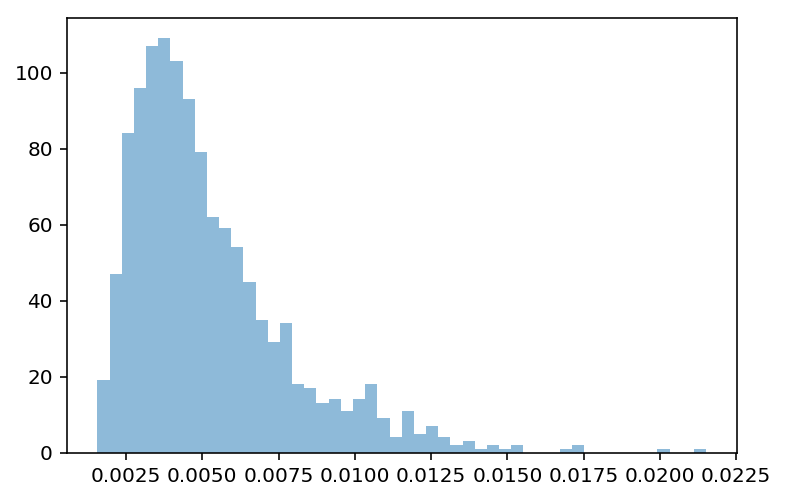

In [101]:
plt.hist(y_preds[:, 9], bins=50, alpha=0.5)
plt.show()

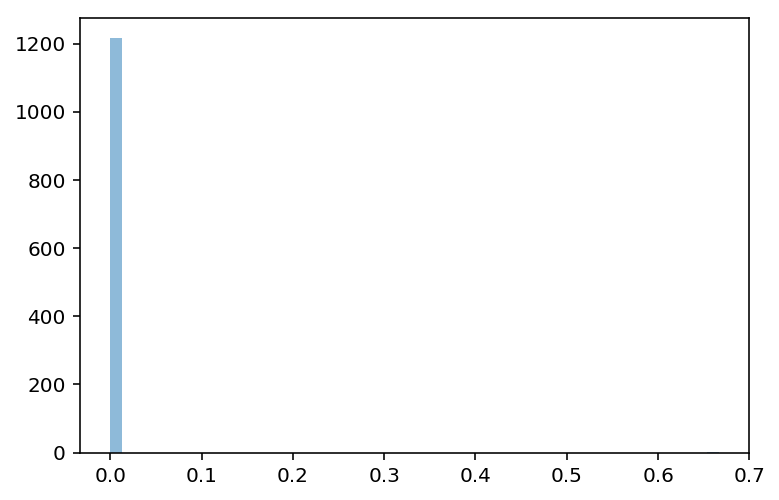

In [119]:
plt.hist(assigned_y_preds[:, 9], bins=50, alpha=0.5)
plt.show()

In [113]:
np.unique(assigned_y_preds[:, 9])

array([0.        , 0.66666667])

In [109]:
np.unique(y_trues[:, 9])

array([0.        , 0.33333333, 0.5       , 0.66666667])

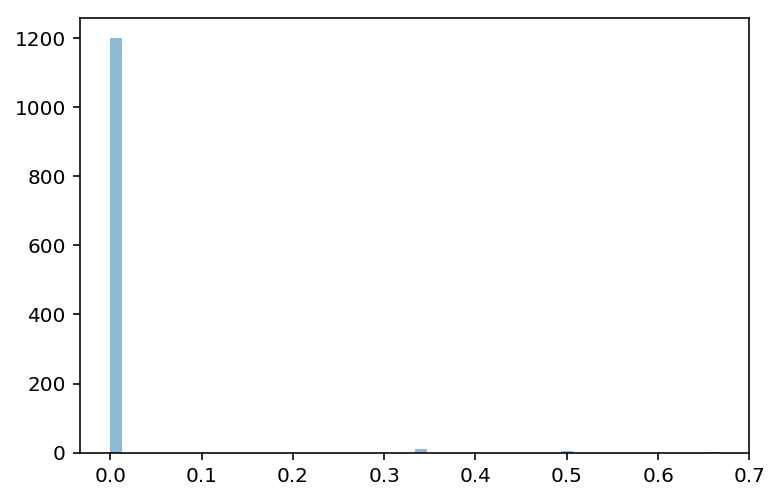

In [102]:
plt.hist(y_trues[:, 9], bins=50, alpha=0.5)
plt.show()

## ヒストグラムベースやる

In [49]:
for i, row in pd.Series(y_trues[:, 0]).value_counts(normalize=True).sort_index().cumsum().reset_index().iterrows():
    value, ratio = row.values
    print(value, ratio)

0.3333333333333333 0.009868421052631578
0.4444444444444444 0.012335526315789474
0.5 0.019736842105263157
0.5555555555555556 0.028782894736842105
0.6666666666666666 0.10279605263157894
0.7777777777777778 0.24342105263157893
0.8333333333333334 0.2606907894736842
0.8888888888888888 0.5106907894736842
1.0 1.0


In [118]:
def assign_histogram_band(all_y_trues, all_y_preds):
    all_res = []
    for col_idx in range(30):
        y_trues = all_y_trues[:, col_idx].copy()
        y_preds = all_y_preds[:, col_idx].copy()

        y_preds_df = pd.DataFrame(y_preds, columns=['y_pred'])
        y_preds_df['normed_rank'] = (y_preds_df.y_pred.rank() / y_preds_df.shape[0]).values
        _bef_ratio = -1
        for i, row in pd.Series(y_trues).value_counts(normalize=True).sort_index().cumsum().reset_index().iterrows():
            value, ratio = row.values
            print(((y_preds_df.normed_rank > _bef_ratio).values & (y_preds_df.normed_rank <= ratio).values).sum())
            y_preds_df.loc[(y_preds_df.normed_rank > _bef_ratio).values & (y_preds_df.normed_rank <= ratio).values, 'y_pred'] = value
            _bef_ratio = ratio
        all_res.append(y_preds_df.y_pred.values)
    return np.asarray(all_res).T

In [119]:
res = assign_histogram_band(y_trues, y_preds)
res.shape

12
3
9
11
90
170
21
305
595
283
193
19
175
164
157
9
91
125
1076
73
8
38
21
171
105
84
285
571
65
158
14
273
706
140
65
52
167
792
51
242
47
361
366
83
7
34
24
385
304
41
168
132
83
11
42
50
723
222
16
144
111
1199
10
6
1
399
287
35
290
205
689
206
19
136
166
1126
42
2
27
19
1186
17
3
7
3
1140
31
2
30
12
1035
94
6
45
36
447
133
33
197
406
796
249
22
111
38
506
275
19
196
220
1215
1
22
64
7
107
150
243
35
270
318
5
5
12
72
107
48
250
717
30
46
33
129
812
98
23
26
18
2
4
34
40
45
156
935
1
1
1
2
18
37
33
152
971
1
2
1
1
7
8
4
17
46
50
13
68
255
188
80
214
261
467
134
31
213
370
857
247
20
70
22
381
226
29
224
356
1
2
9
65
149
31
441
518


(1216, 30)

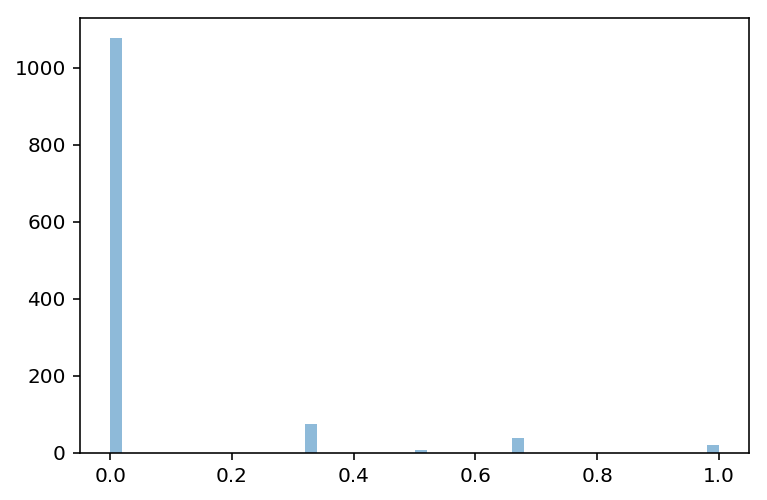

In [104]:
plt.hist(y_trues[:, 2], bins=50, alpha=0.5)
plt.show()

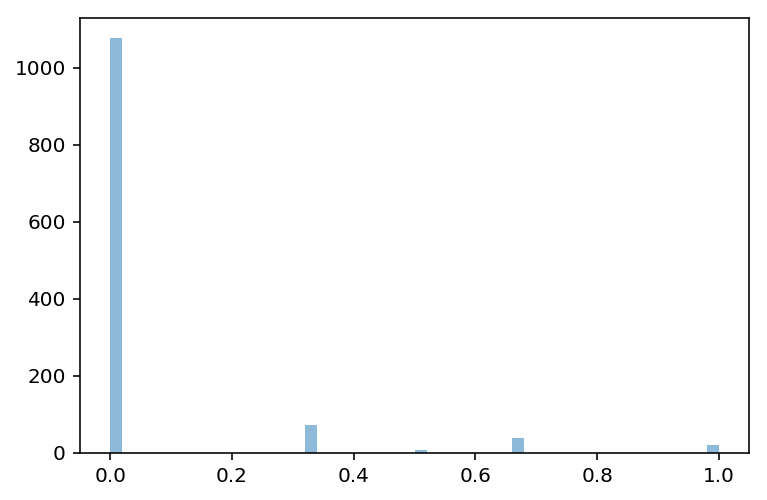

In [105]:
plt.hist(res[:, 2], bins=50, alpha=0.5)
plt.show()

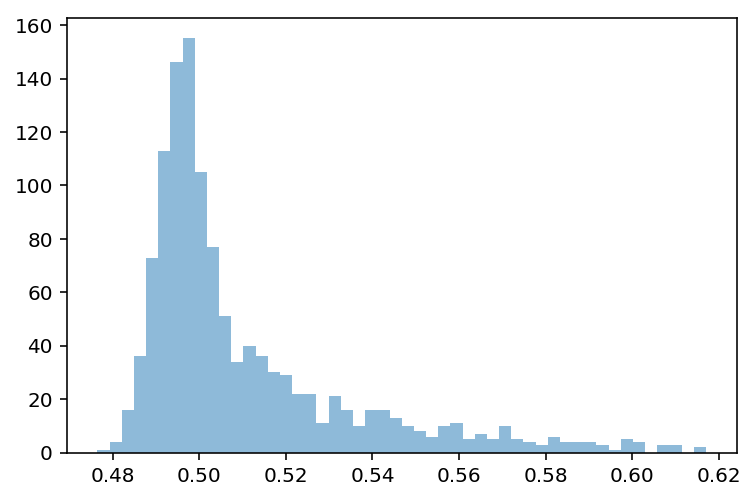

In [106]:
plt.hist(y_preds[:, 2], bins=50, alpha=0.5)
plt.show()

In [107]:
compute_spearmanr(y_trues, res)

[0.33229973211974567,
 0.5813069758073993,
 0.38346781825695514,
 0.25900115792697764,
 0.3423576956053028,
 0.457355438797686,
 0.3360614416191135,
 0.48582129422637343,
 0.5167068901448133,
 -0.014177777347443979,
 0.39447974962945076,
 0.7330118680566508,
 0.5267377233629459,
 0.07623794958305534,
 0.6565733373935888,
 0.5979694846545532,
 0.7680301112339899,
 0.27911396173337305,
 0.5994798166990314,
 -0.0008230452674897118,
 0.4533616382723037,
 0.12858762727147793,
 0.3727093942502885,
 0.01954998221101455,
 0.0546843213856112,
 0.25226098306415906,
 0.7454348444326047,
 0.22270752734441374,
 0.5946536993786803,
 0.15444370999021162]

In [127]:
np.mean(compute_spearmanr(y_trues, res))

0.36908493434593226

In [128]:
np.mean(compute_spearmanr(y_trues, y_preds))

0.3751535549176177

In [132]:
np.mean(compute_spearmanr(y_trues, assigned_y_preds))

0.3615782002591646

In [123]:
compute_spearmanr(y_trues, assigned_y_preds)

[0.33694931413303936,
 0.5525639350710876,
 0.3514474183190364,
 0.2790888271349788,
 0.32845886497854104,
 0.4718309500798249,
 0.30166672081003904,
 0.4616868042196653,
 0.4717855816387441,
 -0.003415984857890416,
 0.40183148092510923,
 0.7008105302924496,
 0.4343182161053076,
 -0.0045624210801053135,
 0.5337619564287965,
 0.5680669608518802,
 0.7703271971978511,
 0.30327653885548134,
 0.5896460332270635,
 -0.0008230452674897118,
 0.438142569365688,
 0.20426918996372181,
 0.3569257568408338,
 0.042490688054867144,
 0.14127863610770514,
 0.24918357377616956,
 0.7471845567539979,
 0.16108587246863346,
 0.6114954390512181,
 0.046573846328690896]

## label 見てみる

In [136]:
df = pd.read_csv('../mnt/inputs/origin/train.csv')

In [137]:
df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


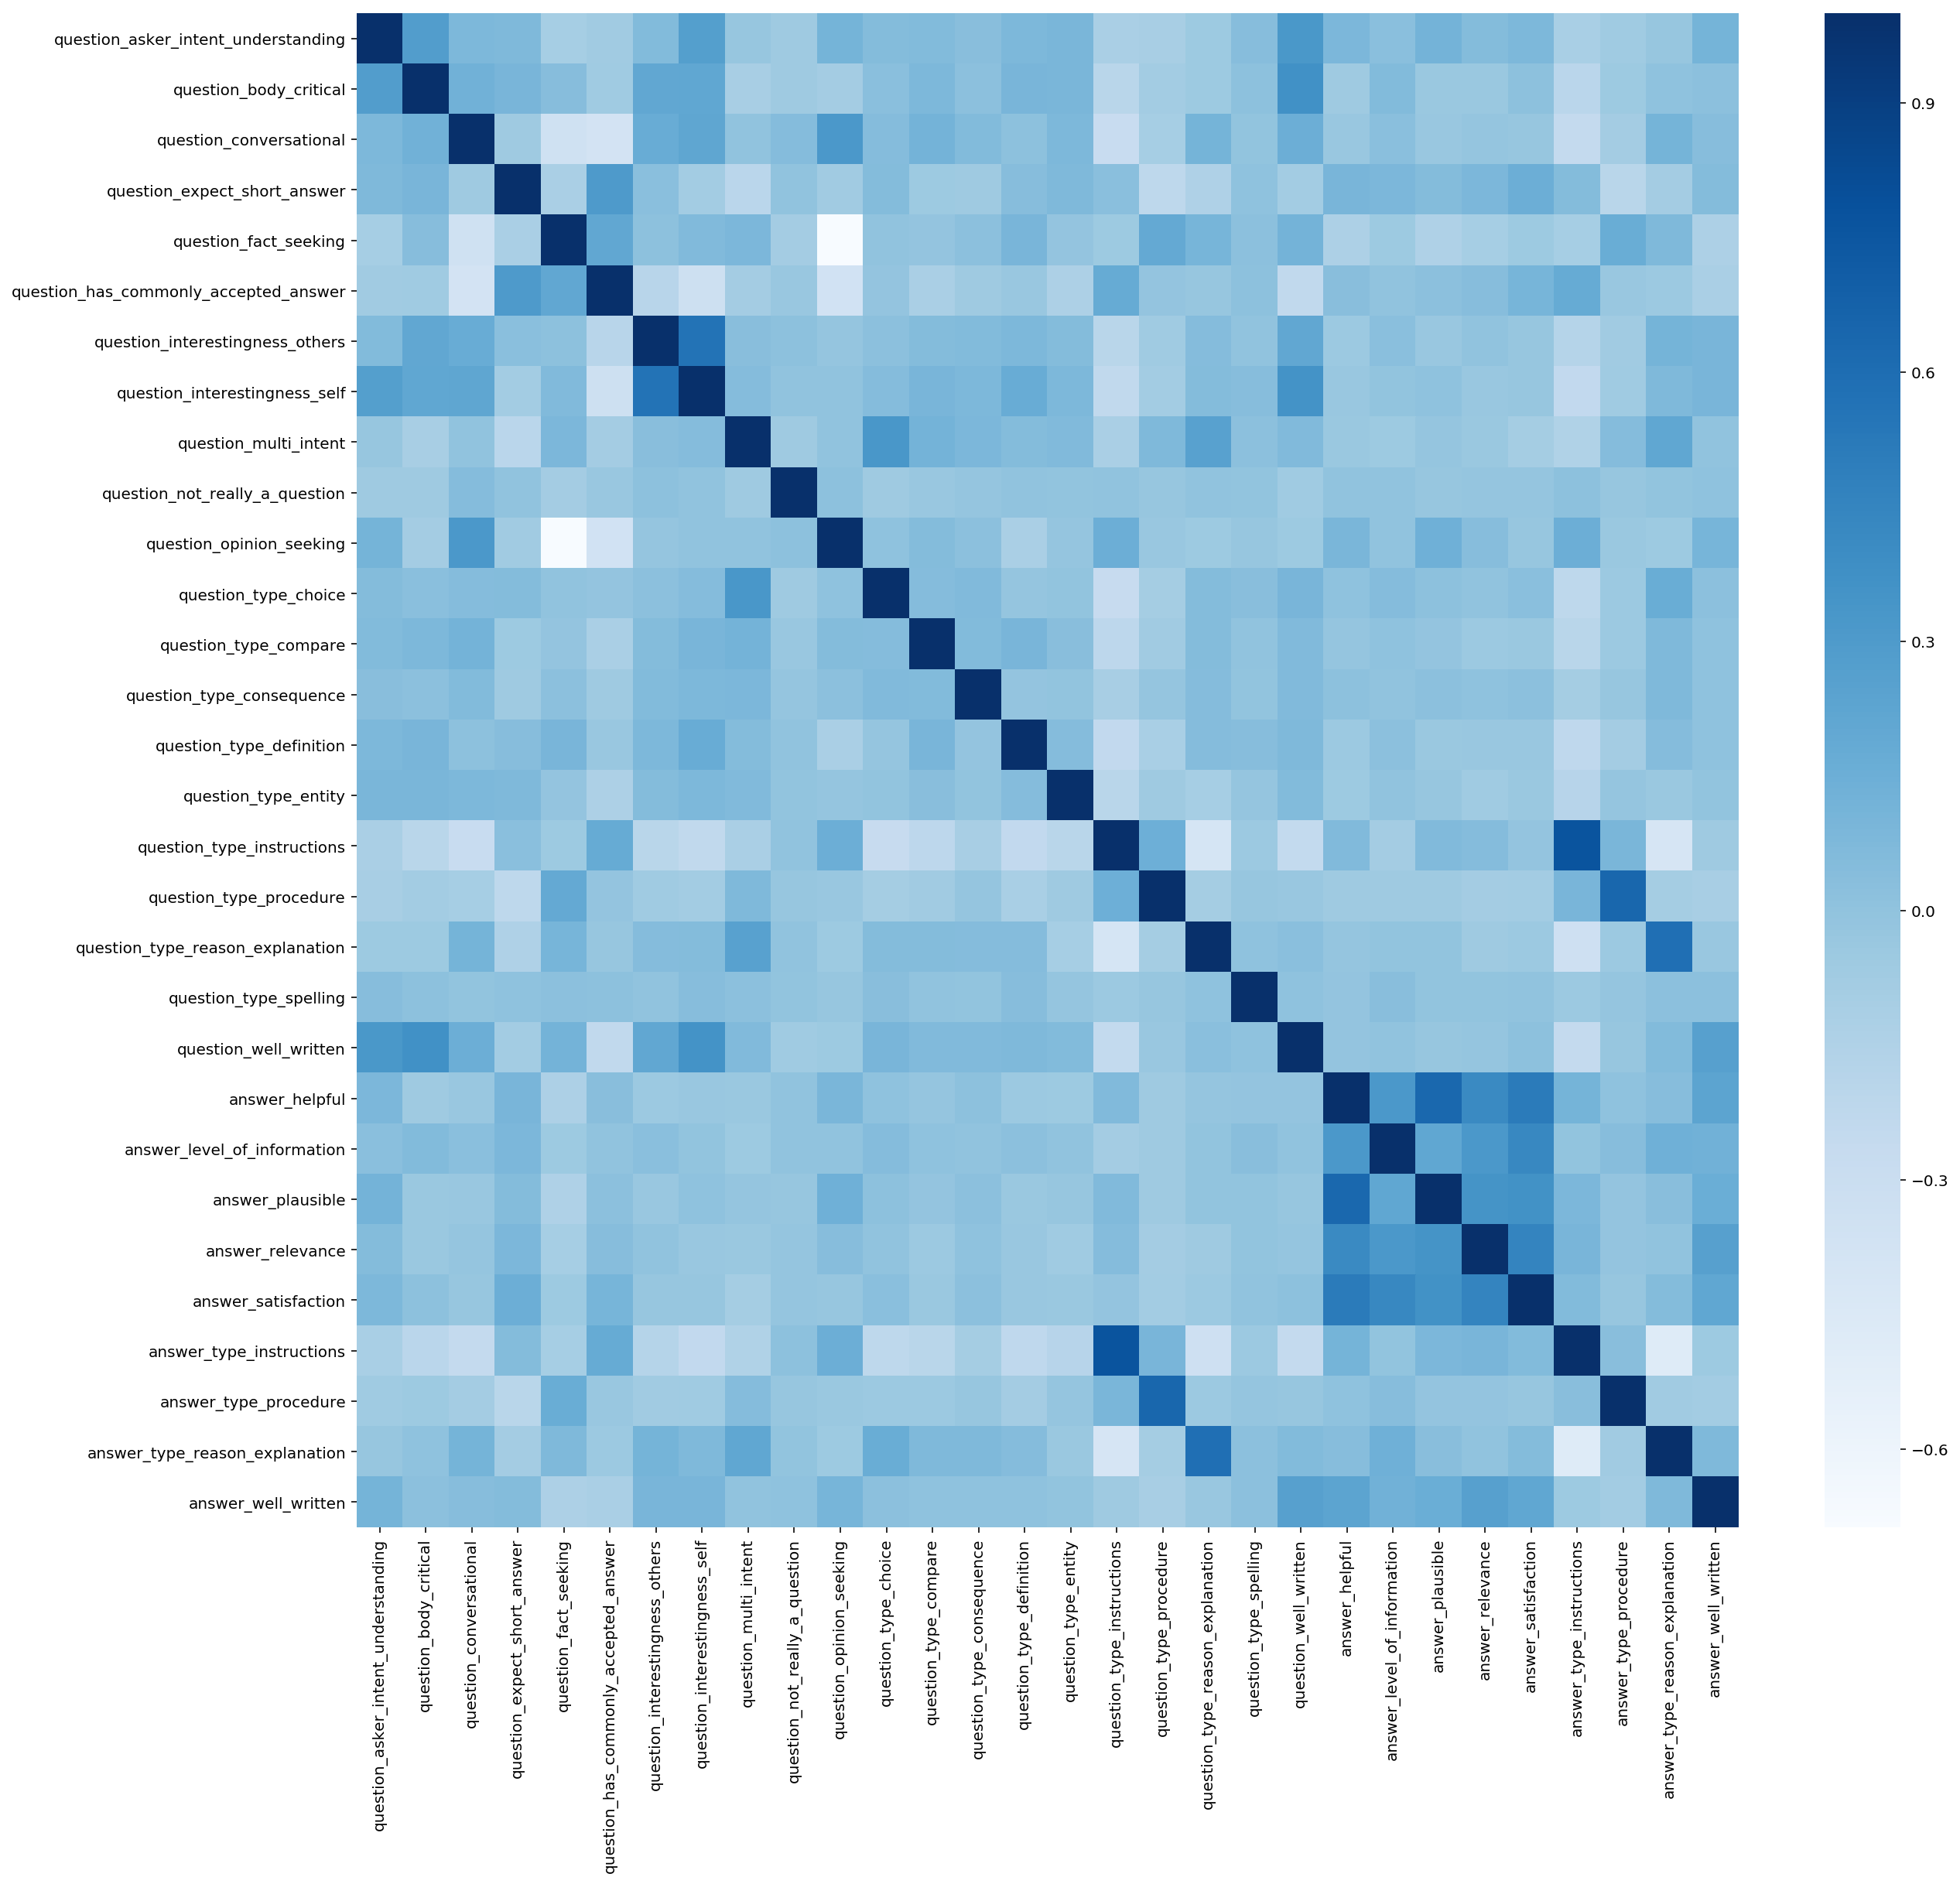

In [142]:
plt.figure(figsize=(20, 18))
sns.heatmap(df.iloc[:, 11:].corr(method='spearman'), cmap='Blues')

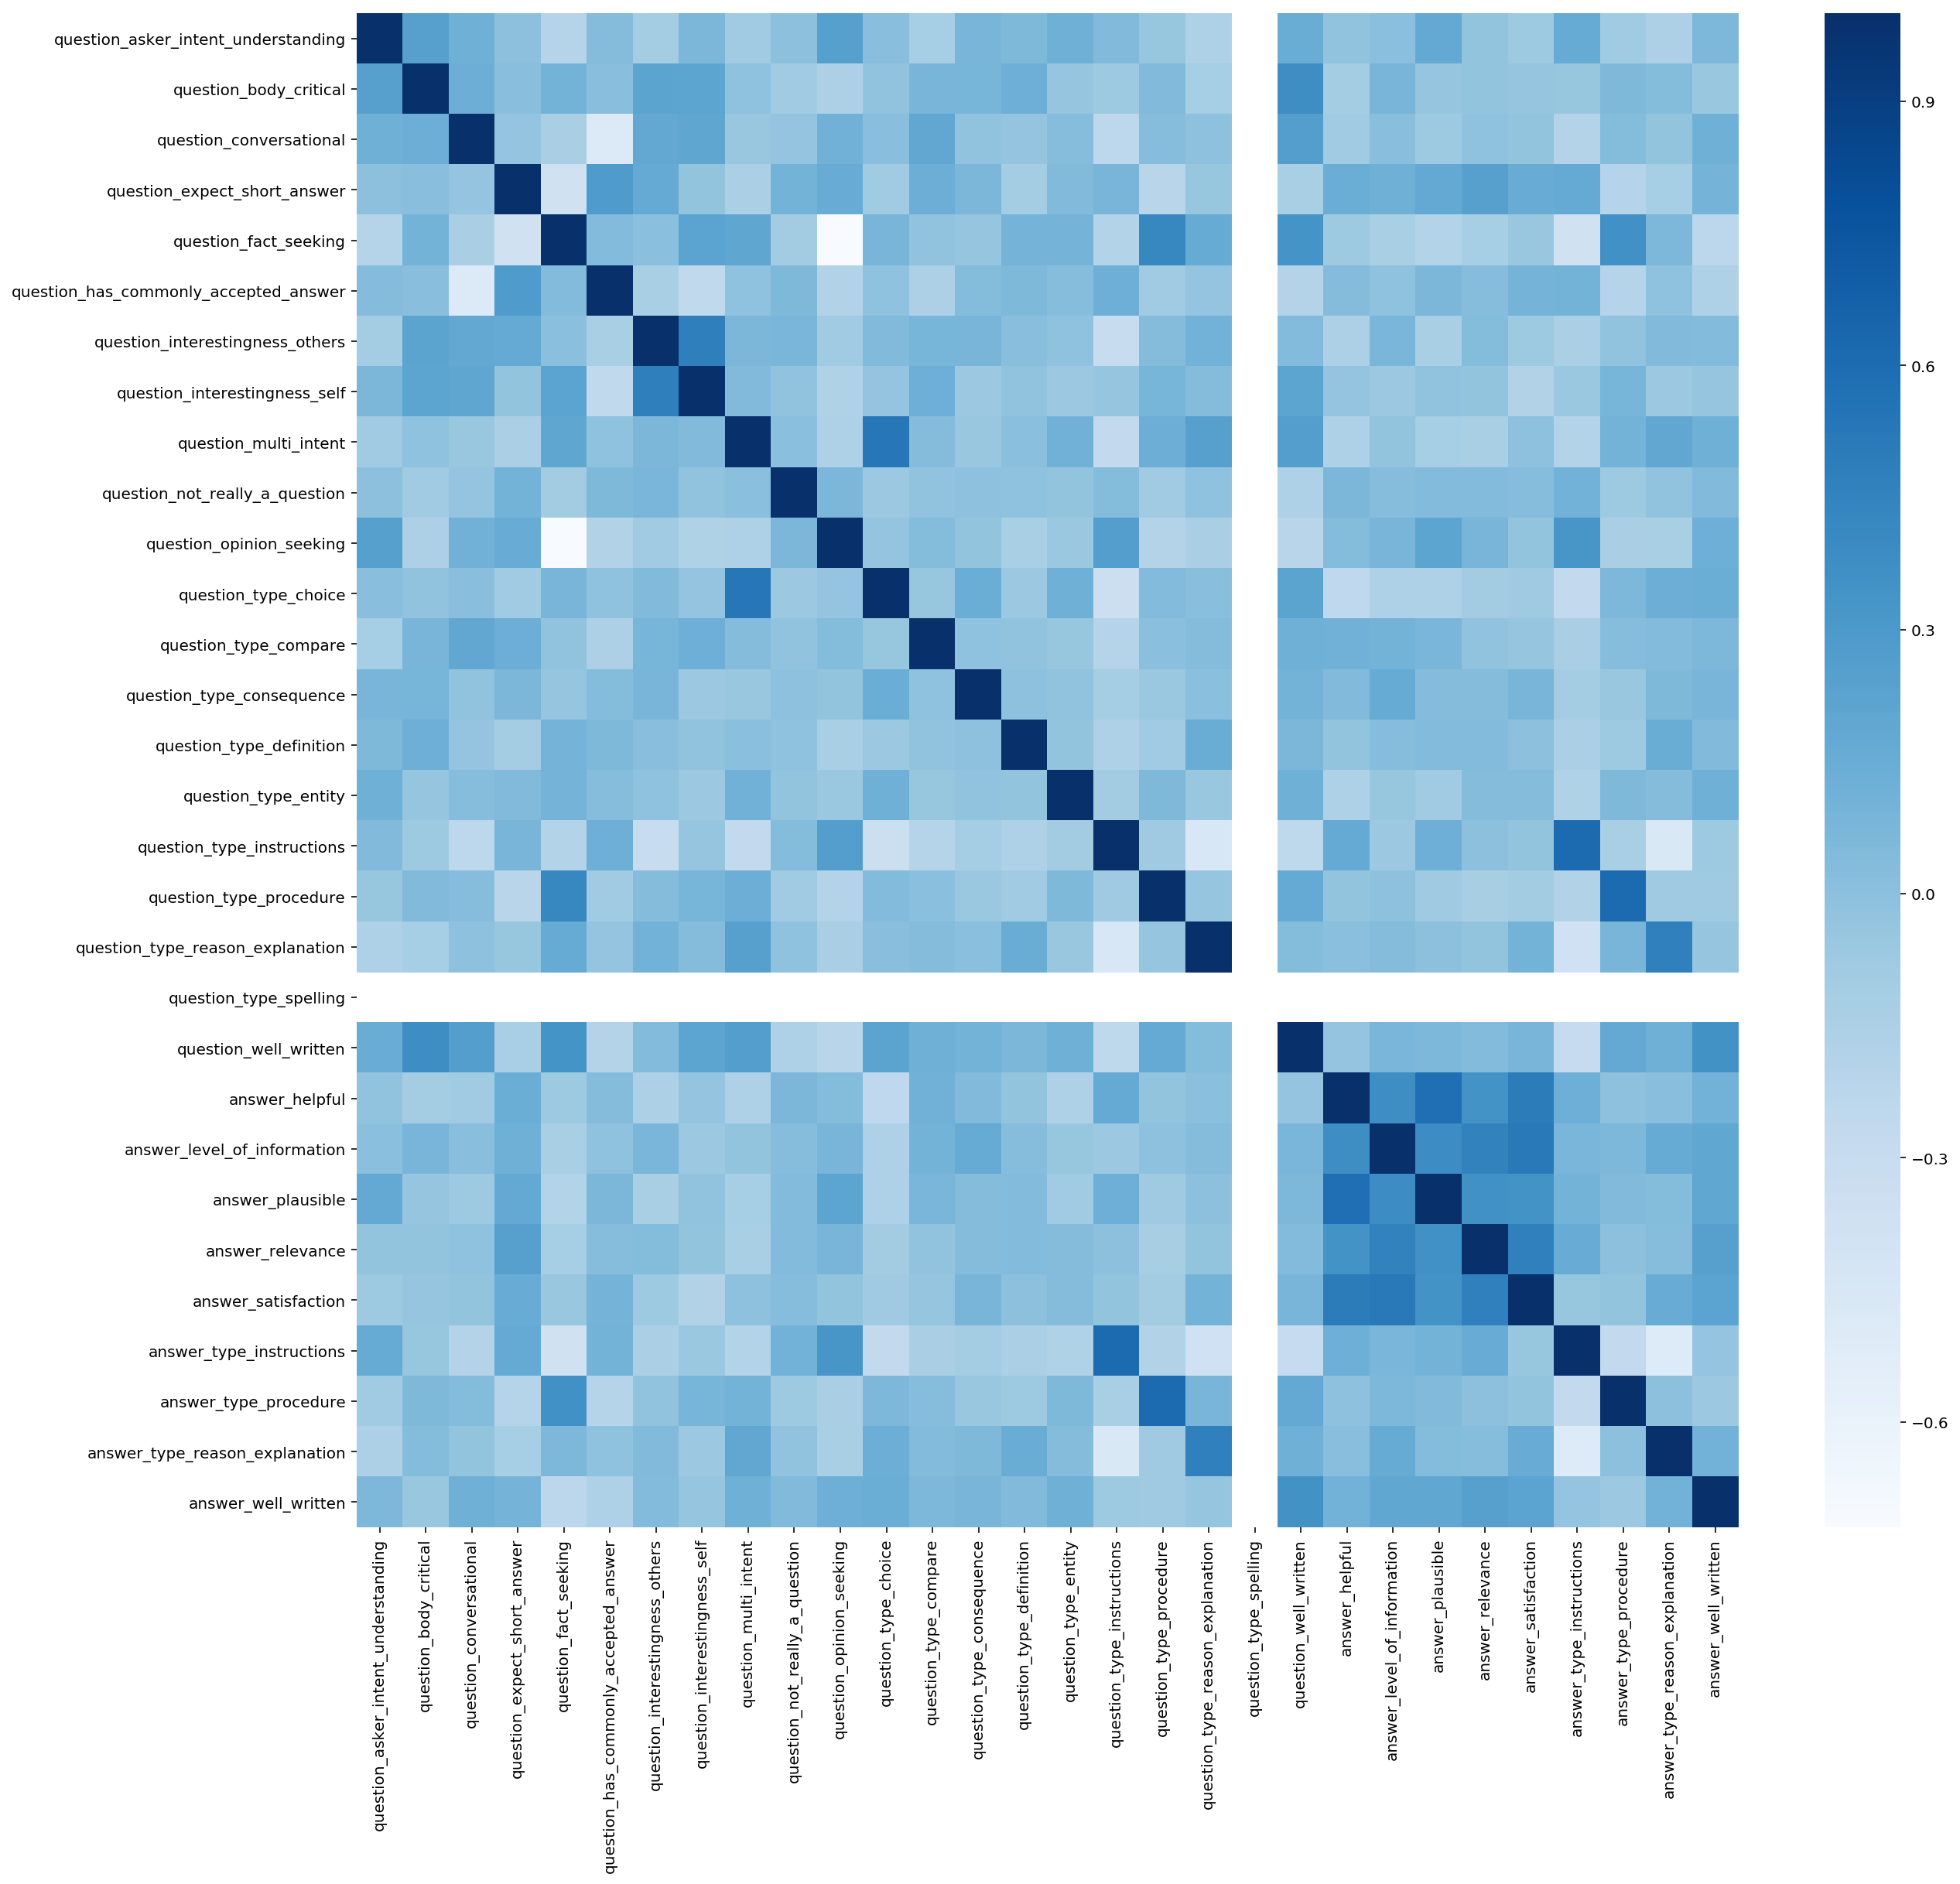

In [144]:
plt.figure(figsize=(20, 18))
sns.heatmap(df.query('question_user_name == answer_user_name').iloc[:, 11:].corr(method='spearman'), cmap='Blues')

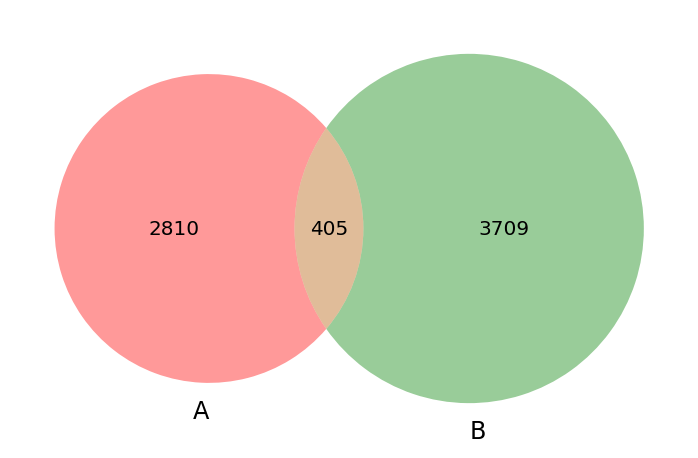

In [148]:
venn2([set(df.question_user_name), set(df.answer_user_name)])

In [152]:
df.iloc[:, 11:].columns.tolist()

['question_asker_intent_understanding',
 'question_body_critical',
 'question_conversational',
 'question_expect_short_answer',
 'question_fact_seeking',
 'question_has_commonly_accepted_answer',
 'question_interestingness_others',
 'question_interestingness_self',
 'question_multi_intent',
 'question_not_really_a_question',
 'question_opinion_seeking',
 'question_type_choice',
 'question_type_compare',
 'question_type_consequence',
 'question_type_definition',
 'question_type_entity',
 'question_type_instructions',
 'question_type_procedure',
 'question_type_reason_explanation',
 'question_type_spelling',
 'question_well_written',
 'answer_helpful',
 'answer_level_of_information',
 'answer_plausible',
 'answer_relevance',
 'answer_satisfaction',
 'answer_type_instructions',
 'answer_type_procedure',
 'answer_type_reason_explanation',
 'answer_well_written']

In [164]:
_dict = df['question_asker_intent_understanding'].drop_duplicates().sort_values().reset_index(drop=True).reset_index().set_index('question_asker_intent_understanding').to_dict()['index']
_dict

{0.3333333333333333: 0,
 0.4444444444444444: 1,
 0.5: 2,
 0.5555555555555556: 3,
 0.6666666666666666: 4,
 0.7777777777777778: 5,
 0.8333333333333334: 6,
 0.8888888888888888: 7,
 1.0: 8}

In [165]:
df['question_asker_intent_understanding'].map(_dict)

0       8
1       8
2       7
3       7
4       8
       ..
6074    8
6075    8
6076    7
6077    8
6078    8
Name: question_asker_intent_understanding, Length: 6079, dtype: int64

In [169]:
torch.zeros(y_trues.shape).shape

torch.Size([1216, 30])

In [170]:
a = torch.nn.Softmax()

In [182]:
a(torch.tensor(y_preds)).argmax(dim=1)#.sum(dim=1).shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([ 0, 24, 24,  ..., 24,  0, 24])

In [186]:
torch.tensor(y_preds).size()

torch.Size([1216, 30])